<a href="https://colab.research.google.com/github/aminrabinia/Image-Captioning-with-InceptionV3-/blob/main/GLOVE_Captioning_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline model at https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

In [1]:
#!pip uninstall keras
# !pip install keras==2.3.1
#!pip uninstall tensorflow
# !pip install tensorflow==2.2

In [2]:
from os import listdir
from pickle import dump
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.models import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

import numpy as np

In [3]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

# !unzip Flickr8k_Dataset.zip
# !unzip Flickr8k_text.zip

In [4]:

def extract_features(directory):
	model = InceptionV3(weights='imagenet')
	model = Model(inputs=model.input, outputs=model.layers[-2].output)
	print(model.summary())
	features = dict()
	print("------------------------")

	for name in listdir(directory):
		filename = directory + '/' + name		
		img = load_img(filename, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
		x = img_to_array(img)		
    # Add one more dimension
		x = np.expand_dims(x, axis=0)		
		# preprocess the images using preprocess_input() from inception module
		x = preprocess_input(x)		

		feature = model.predict(x, verbose=0)
		print(feature)
		
		image_id = name.split('.')[0]
		features[image_id] = feature
		#print('>%s' % name)
	return features

# extract features from all images
directory = r'F:\Flickr8k\Flickr8k_Dataset\Flicker8k_Dataset'
features = extract_features(directory)

print('Extracted Features: %d' % len(features))

dump(features, open('features.pkl', 'wb'))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
import string

# load doc into memory
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items(): # for each img
		for i in range(len(desc_list)): # there are 5 captions
			desc = desc_list[i]
			desc = desc.split() # tokenize
			desc = [word.lower() for word in desc] # convert to lower case
			desc = [w.translate(table) for w in desc] # remove punctuation from each token
			desc = [word for word in desc if len(word)>1] # remove hanging 's' and 'a'
			desc = [word for word in desc if word.isalpha()] # remove tokens with numbers in them
			desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()


filename =  r'F:\Flickr8k\Flickr8k_text\Flickr8k.token.txt'
doc = load_doc(filename) # load descriptions doc
descriptions = load_descriptions(doc) # gets img ids and captions
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)
save_descriptions(descriptions, 'descriptions.txt')

vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size after cleaning: %d' % len(vocabulary))


Loaded: 8092 
Vocabulary Size after cleaning: 8763


In [6]:
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from pickle import dump

# load doc into memory


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# load a pre-defined list of photo identifiers


def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:  # skip empty lines
            continue
        identifier = line.split('.')[0]  # get the image identifier
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)  # descriptions already saved loaded here
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]

        if image_id in dataset:  # skip images not in the set
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'

            descriptions[image_id].append(desc)
    return descriptions

# load photo features


def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}  # {id : features}
    return features

# covert a dictionary of clean descriptions to a list of descriptions


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions


def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words


def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


# load training dataset (6K) just has the img ids
# filename = '/content/Flickr_8k.trainImages.txt'
filename = r'F:\Flickr8k\Flickr8k_text\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description max Length: %d' % max_length)


Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description max Length: 34


In [7]:
# download pretrained weights for embedding: GLOVE
# !wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip 
# !unzip glove.6B.zip 

In [8]:
EMBEDDING_DIM = 300 # to match glove 300d
USE_GLOVE= True

if USE_GLOVE:
  GLOVE_file= 'glove.6B.300d.txt' #'glove.6B.300d.txt'
  embeddings_index = {}
  with open(GLOVE_file,encoding='utf-8') as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  print('Found %s word vectors.' % len(embeddings_index))
  f.close()

  word_index = tokenizer.word_index
  print('num_words: ', vocab_size)
  embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  print('Total number of null word embeddings:', 
        np.sum(np.sum(embedding_matrix, axis=1) == 0))

Found 400000 word vectors.
num_words:  7579
Total number of null word embeddings: 763


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam

# create sequences of images, input sequences and output words for an image


def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences(
                [in_seq], maxlen=max_length, padding='post', truncating='post')[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

# data generator, intended to be used in a call to model.fit_generator()


def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(
                tokenizer, max_length, desc_list, photo, vocab_size)
            # yield [[in_img, in_seq], out_word]
            # MY !!!!!!!!!!
            yield ([in_img,in_seq],out_word)

# define the captioning model


def define_model(vocab_size, max_length):
    # feature extractor model
    # InceptionV3 last layer
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.125)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))  # gets data from descriptions
    se1 = Embedding(vocab_size, EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    trainable=True, mask_zero=True)(inputs2)
    se2 = Dropout(0.125)(se1)
    se3 = GRU(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])  # concatinates image + caption
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


model = define_model(vocab_size, max_length)
#model = load_model('model_13.h5')
# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(
        train_descriptions, train_features, tokenizer, max_length, vocab_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # model.fit(generator, epochs=i, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 300)      2273700     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [19]:
from numpy import argmax
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length, padding='post', truncating='post')
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# prepare tokenizer on train set

# load training dataset (6K)
# filename = '/content/Flickr_8k.trainImages.txt'
filename= r'F:\Flickr8k\Flickr8k_text\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = 34 #max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = r'F:\Flickr8k\Flickr8k_text\Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
# filename = '/content/model_13.h5'
filename = 'model_9.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.490776
BLEU-2: 0.251767
BLEU-3: 0.172666
BLEU-4: 0.079267


startseq man in blue shirt is riding canoe on the water endseq


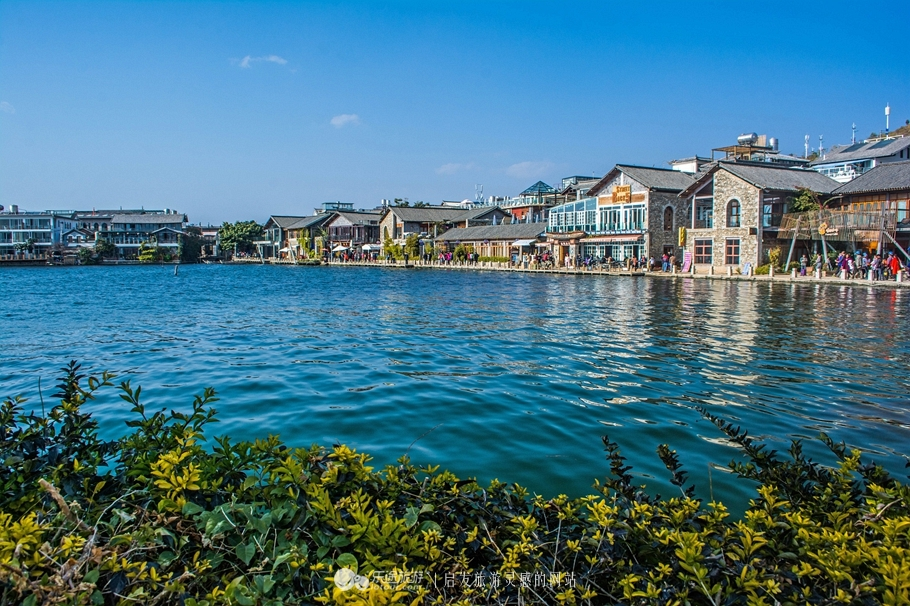

In [20]:
from pickle import load
from numpy import argmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image

# map an integer to a word


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image


def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences(
            [sequence], maxlen=max_length, padding='post', truncating='post')
        # predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text


def extract_features(filename):
    model = InceptionV3(weights='imagenet')
    model = Model(inputs=model.input, outputs=model.layers[-2].output)
    img = load_img(filename, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x, verbose=0)
    return feature


# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model_9.h5')
# load and prepare the photograph
# photo_name='/content/Flicker8k_Dataset/179009558_69be522c63.jpg'
# photo_name = r'F:\Flickr8k\Flickr8k_Dataset\Flicker8k_Dataset\179009558_69be522c63.jpg'
photo_name=r'H:\test_dataset\双廊.jpeg'
photo = extract_features(photo_name)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
Image.open(photo_name)
